# shadow detection in muli-spectral imagery

There are several methods to extract an illumination component of an image. This can be done by looking at the spectral properties of each individual pixel in an multi-spectral image. In the following notebook some of these methods are demonstrated.

### import of funcitons from libraries
First we need to import some generic libraries for plotting and file manipulation

In [1]:
import matplotlib.pyplot as plt

import os
import numpy as np

Than more specific functions can be imported from the **dhdt** library

In [2]:
from dhdt.generic.mapping_io import read_geo_image
from dhdt.generic.mapping_tools import pix2map, get_bbox, pix_centers
from dhdt.generic.handler_sentinel2 import get_s2_image_locations, get_s2_dict

from dhdt.input.read_sentinel2 import list_central_wavelength_msi, read_stack_s2, s2_dn2toa

from dhdt.preprocessing.shadow_transforms import apply_shadow_transform, ica
from dhdt.preprocessing.image_transforms import mat_to_gray, inverse_tangent_transformation

### data preparation
A local file directory is given here, hence use your own file path.

In [3]:
dat_dir = '/local/path/S2A_MSIL1C_20201019T213531_N0209_R086_T05VMG_20201019T220042.SAFE' 


Here we take the high resolution (10 meter) data of Sentinel-2. We also specify a subset of the data, as the scenes are typically 100x100km.

In [4]:
boi = ['red', 'green', 'blue', 'nir']
h,w = 500, 500
s2_df = list_central_wavelength_msi()
s2_df = s2_df[s2_df['common_name'].isin(boi)]
s2_df, datastrip_id = get_s2_image_locations(os.path.join(dat_dir, 'MTD_MSIL1C.xml'), s2_df)
s2_dict = get_s2_dict(s2_df)


In [5]:
im_stack, spatialRef, geoTransform, targetprj = read_stack_s2(s2_df)
#im_stack = s2_dn2toa(im_stack)
im_stack = mat_to_gray(im_stack)
I_extent = get_bbox(geoTransform)
I_x,I_y = pix_centers(geoTransform)
m,n = im_stack.shape[0], im_stack.shape[1]

j_min, i_min = np.random.randint(w, n-w), np.random.randint(h, m-h)
j_max, i_max = j_min + w, i_min + h

im_stack,I_x,I_y = im_stack[i_min:i_max,j_min:j_max,:], I_x[i_min:i_max,j_min:j_max], I_y[i_min:i_max,j_min:j_max]

Now the subset can be plotted, in this case, the near-infrared band.

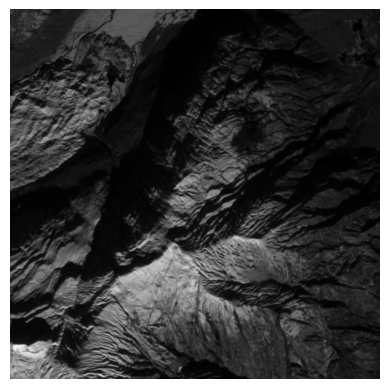

In [6]:
plt.imshow(im_stack[...,-1], cmap=plt.cm.gray), plt.axis('off');

Get the indices of the different bands

In [7]:
i_bl = np.flatnonzero(s2_df['common_name']=='blue')[0]
i_gr = np.flatnonzero(s2_df['common_name'] == 'green')[0]
i_rd = np.flatnonzero(s2_df['common_name']=='red')[0]
i_nr = np.flatnonzero(s2_df['common_name'] == 'nir')[0]

### main processing
Estimate the different shadow transforms, and strech the histogram of the outer intensity regions, so differences between transforms are better visible.

In [8]:
S_siz = apply_shadow_transform('siz',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_isi = apply_shadow_transform('isi',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_sei = apply_shadow_transform('sei',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_siz = 1 - inverse_tangent_transformation(S_siz)
S_isi = 1 - inverse_tangent_transformation(S_isi)
S_sei = 1 - inverse_tangent_transformation(S_sei)

Now the different shadow transforms of the subset can be plotted.

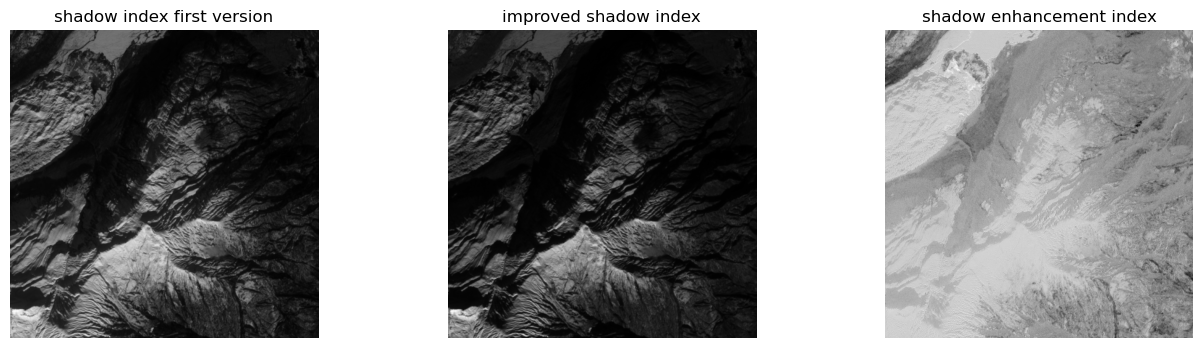

(Text(0.5, 1.0, 'shadow enhancement index'),
 (-0.5, 499.5, 499.5, -0.5),
 (-0.5, 499.5, 499.5, -0.5),
 (-0.5, 499.5, 499.5, -0.5),
 None)

In [9]:
plt.rcParams['figure.figsize'] = [16.,4.]
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex='col', sharey='row')
ax1.imshow(S_siz, cmap=plt.cm.gray), ax2.imshow(S_isi, cmap=plt.cm.gray), ax3.imshow(S_sei, cmap=plt.cm.gray)
ax1.set_title('shadow index first version'), ax2.set_title('improved shadow index'), 
ax3.set_title('shadow enhancement index'), ax1.axis('off'), ax2.axis('off'), ax3.axis('off'), plt.show();

Even more shadow transforms exist, hence calculate these.

In [12]:
S_fcs = apply_shadow_transform('fcsdi',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])
S_csi = apply_shadow_transform('csi',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])
S_nsd = apply_shadow_transform('nsvdi',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_fcs = 1 - inverse_tangent_transformation(S_fcs)
S_csi = inverse_tangent_transformation(S_csi)
S_nsd = 1 - inverse_tangent_transformation(S_nsd)

... and do the plotting

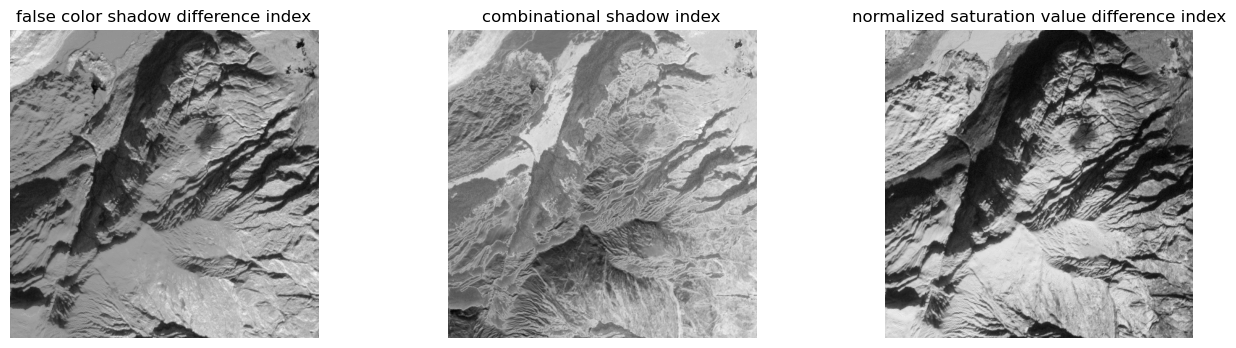

In [13]:
plt.rcParams['figure.figsize'] = [16.,4.]
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex='col', sharey='row')

ax1.imshow(S_fcs, cmap=plt.cm.gray), ax2.imshow(S_csi, cmap=plt.cm.gray), ax3.imshow(S_nsd, cmap=plt.cm.gray)
ax1.set_title('false color shadow difference index'), ax2.set_title('combinational shadow index'), 
ax3.set_title('normalized saturation value difference index'), ax1.axis('off'), ax2.axis('off'), ax3.axis('off')
plt.show()

Even more shadow transforms exist, hence calculate these.

In [14]:
S_sil = apply_shadow_transform('sil',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_sr = apply_shadow_transform('sr',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_sdi = apply_shadow_transform('sdi',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_sil = 1 - inverse_tangent_transformation(S_sil)
S_sr = 1 - inverse_tangent_transformation(S_sr)
S_sdi = inverse_tangent_transformation(S_sdi)

... and do the plotting

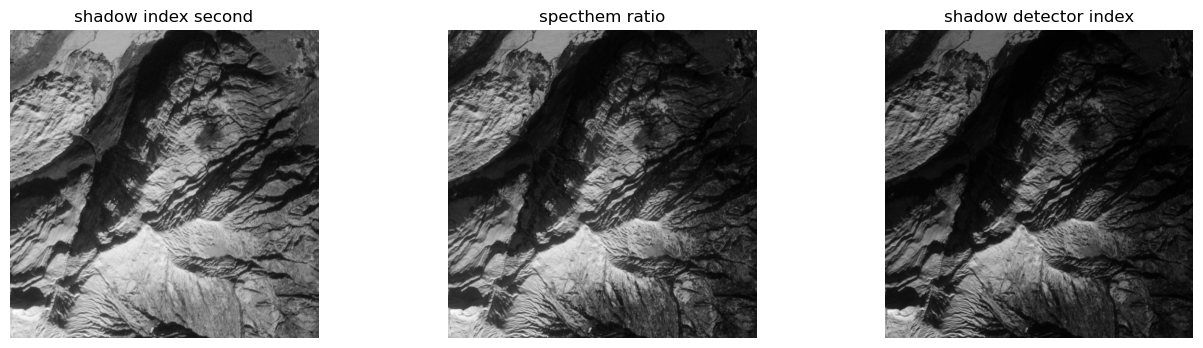

In [15]:
plt.rcParams['figure.figsize'] = [16.,4.]
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex='col', sharey='row')
ax1.imshow(S_sil, cmap=plt.cm.gray), ax2.imshow(S_sr, cmap=plt.cm.gray), ax3.imshow(S_sdi,cmap=plt.cm.gray)
ax1.set_title('shadow index second'), ax2.set_title('specthem ratio'), ax3.set_title('shadow detector index')
ax1.axis('off'), ax2.axis('off'), ax3.axis('off');

Even more shadow transforms exist, hence calculate these.

In [16]:
S_ssi = apply_shadow_transform('sisdi',im_stack[...,i_bl], im_stack[...,i_gr],[],im_stack[...,i_rd],
                               im_stack[...,i_nr], [])

S_mix = apply_shadow_transform('mixed',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_msf = apply_shadow_transform('msf',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_ssi = 1 - inverse_tangent_transformation(S_ssi)
S_mix = inverse_tangent_transformation(S_mix)
S_msf = inverse_tangent_transformation(S_msf)

... and do the plotting

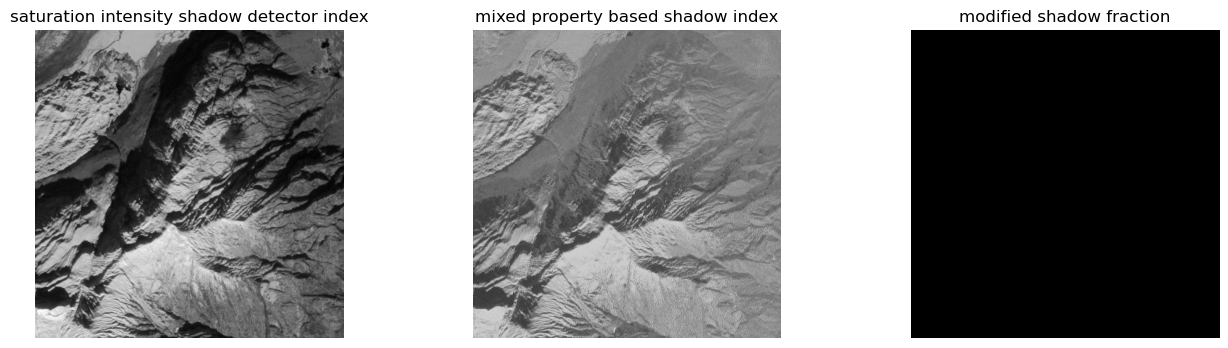

In [17]:
plt.rcParams['figure.figsize'] = [16.,4.]
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex='col', sharey='row')

ax1.imshow(S_ssi, cmap=plt.cm.gray), ax2.imshow(S_mix, cmap=plt.cm.gray), ax3.imshow(S_msf, cmap=plt.cm.gray)
ax1.set_title('saturation intensity shadow detector index'), ax2.set_title('mixed property based shadow index'), 
ax3.set_title('modified shadow fraction'), ax1.axis('off'), ax2.axis('off'), ax3.axis('off');


Even more shadow transforms exist, hence calculate these.

In [18]:
S_cth = apply_shadow_transform('c3',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_sp = apply_shadow_transform('sp',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_shi = apply_shadow_transform('shi',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_cth = inverse_tangent_transformation(S_cth)
S_sp = 1 - inverse_tangent_transformation(S_sp)
S_shi = 1 - inverse_tangent_transformation(S_shi)


... and do the plotting

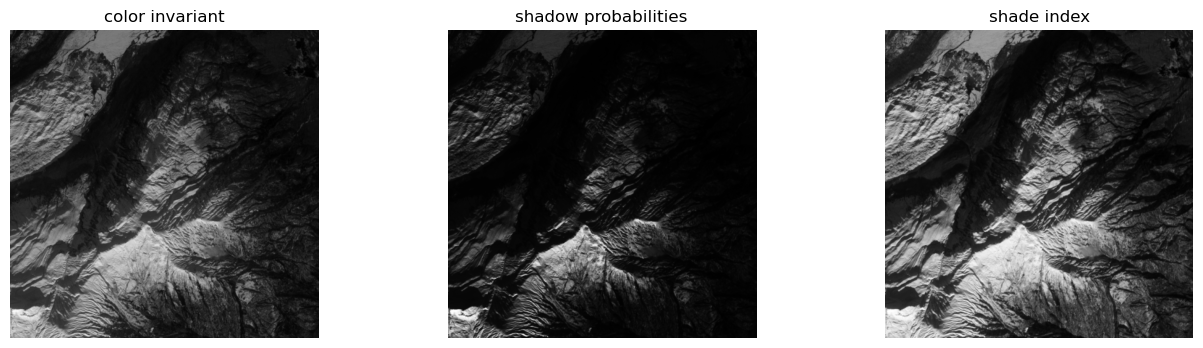

In [19]:
plt.rcParams['figure.figsize'] = [16.,4.]
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex='col', sharey='row')

ax1.imshow(S_cth, cmap=plt.cm.gray), ax2.imshow(S_sp, cmap=plt.cm.gray), ax3.imshow(S_shi, cmap=plt.cm.gray)
ax1.set_title('color invariant'), ax2.set_title('shadow probabilities'), ax3.set_title('shade index')
ax1.axis('off'), ax2.axis('off'), ax3.axis('off');

Even more shadow transforms exist, hence calculate these. Though, this is the last one. 

In [20]:
Even more shadow transforms exist, hence calculate these.S_nri = apply_shadow_transform('nri',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [])

S_ent, R_ent = apply_shadow_transform('entropy',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                               im_stack[...,i_nr], [], a=138.)

S_nri = 1 - inverse_tangent_transformation(S_nri)
S_ent = inverse_tangent_transformation(S_ent)
R_ent = inverse_tangent_transformation(R_ent)

... and do the plotting

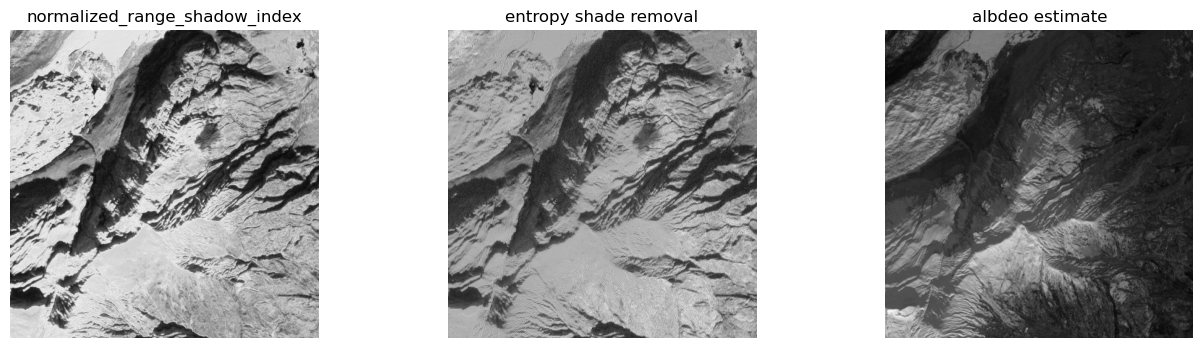

In [21]:
plt.rcParams['figure.figsize'] = [16.,4.]
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex='col', sharey='row')

ax1.imshow(S_nri, cmap=plt.cm.gray), ax2.imshow(S_ent, cmap=plt.cm.gray), ax3.imshow(R_ent, cmap=plt.cm.gray)
ax1.set_title('normalized_range_shadow_index'), ax2.set_title('entropy shade removal'), ax3.set_title('albdeo estimate')
ax1.axis('off'), ax2.axis('off'), ax3.axis('off');